In [1129]:
#from google.colab import output
#output.clear()

In [1130]:
# ライブラリのインストール（初回のみ）
#!pip install japanize-matplotlib

In [1131]:
# （参考）Google Driveにマウントして、ここからデータを読む場合
#from google.colab import drive
#drive.mount('/content/drive')

In [1132]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas_profiling as pdp
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import re
import folium
import warnings
import japanize_matplotlib

warnings.simplefilter('ignore', FutureWarning)
# Set Display Max Columns
pd.set_option("display.max_columns", 50)

# 各種関数

In [1133]:
# 欠損値をplotする
def missing_plot(df):
    cols_has_null = df.isnull().sum().to_frame(name="count").query("count > 0").index
    plt.figure(figsize=(10,4))
    cmap = sns.color_palette("deep", 2)
    ax = sns.heatmap(df[cols_has_null].isnull(), cmap=cmap)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['Not Missing','Missing'])
    plt.title("Missing Values")
    plt.show()
    
#カテゴリーの説明変数の確認とプロット
def category(x,df):

    unit = df.groupby([x]).PRICE.mean()
    display(unit)

    unit_count = df.groupby([x]).PRICE.count()
    display(unit_count)

    unit.plot(kind="bar")
    plt.show()

#正規分布の確認
def check_norm(x):
    plt.hist(x, bins=100)#ヒストグラム表示
    plt.pause(.01)
    stats.probplot(x, dist="norm", plot=plt)#QQプロット表示
    plt.pause(.01)
    p=stats.shapiro(x)#シャピロウィルク検定
    print(p)

def null_check(x,df):
    print("【"+str(x)+"】"+"Train欠損値数:" + str(df[x].isnull().sum()))
    print("【"+str(x)+"】"+"Test欠損値数:" + str(df[x].isnull().sum()))
    

#データ統計量の確認
def get_cat_num_features(df):
    
    num_features = []
    cat_features = []
    
    for col in df.columns:
        if df[col].dtype == "float64":
            num_features.append(col)
        if df[col].dtype == "int64":
            num_features.append(col)
            
        if df[col].dtype == "object":
            cat_features.append(col)
            
    return num_features, cat_features


def get_unique_df(features):
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])
    for col in features.columns:
        v = features[col].unique()
        l = len(v)
        unique_df = unique_df.append({'Feature':col, 
                                     'Unique':v,
                                     'Count':l}, ignore_index=True)
    return unique_df


def get_null_df(features):
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null = features.columns[features.isna().any()].to_list()
    L = len(features)
    for col in col_null:
        T = 0
        if features[col].dtype == "float64":
            T = "Numerical"  
        elif features[col].dtype == "int64":
            T = "Numerical"  
        else:
            T = "Categorical"
        nulls = len(features[features[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Column': col, 
                                          'Type': T,
                                          'Total NaN': nulls,
                                          '%': (nulls / L)*100
                                         }, ignore_index=True)
        
    return col_null_df

def summary(data):
    
    print("Samples --> ", len(data))
    print()
    target = data['PRICE']
    features = data.drop(['PRICE'], axis=1)
    print("Features --> ", len(features.columns))
    print("\n",features.columns)
    
    num_features, cat_features = get_cat_num_features(features)
      
    print()
    print("\nNumerical Features --> ", len(num_features))
    print()
    print(num_features)
    print()
    print("Categorical Features -->", len(cat_features))
    print()
    print(cat_features)
    print()
    print("*************************************************")
    stats = features.describe().T
    
    print()
    print("Value counts of each categorical feature\n")
    for col in cat_features:
        print(col)
        print(features[col].value_counts())
        print()
        
    unique_df = get_unique_df(features)
    
    col_null_df = get_null_df(features)
    
    return {'features':features, 
            'target': target, 
            'stats': stats, 
            'unique_df':unique_df,
            'col_null_df': col_null_df}

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs, y_pred])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title('Observed-Predicted Plot', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def dist_tt(x):
    g=sns.FacetGrid(df_all,hue="D_TYPE",height=5)
    g.map(sns.distplot,x)
    #g.set(xlim=(0,xlim),ylim=(0,ylim))
    g.add_legend()

def hist_tt(x):
    g=sns.FacetGrid(df_all,hue="D_TYPE",height=5)
    g.map(sns.histplot,x)
    #g.set(xlim=(0,xlim),ylim=(0,ylim))
    g.add_legend()

# データの前処理

## データ読み込み

上記より価格との相関が強く見られたBATHRM/HF_BATHRM/ROOMS/BEDROOMS/AYB/GBA/KITCHEN/QUADRANT/CNDTN/SALEDATEでモデルを作成

In [1134]:
#train_df = pd.read_csv("train_set.csv", sep=",", header=0, quotechar="\"")
#test_df = pd.read_csv("test_set.csv", sep=",", header=0, quotechar="\"")
train_df_all = pd.read_csv("./data/DC_train.csv", sep=",", header=0, quotechar="\"")
test_df_all = pd.read_csv("./data/DC_test.csv", sep=",", header=0, quotechar="\"")

train = train_df_all.copy()
test=test_df_all.copy()
train["D_TYPE"] = "Train"
test["D_TYPE"] = "Test"
df_all = pd.concat([train,test],axis=0)
df_all = df_all[df_all["SOURCE"] == "Condominium"]

In [1135]:
train_df_all = train_df_all.copy()
test_df_all = test_df_all.copy()

train_df_all = train_df_all[train_df_all["SOURCE"] == "Condominium"]
test_df_all = test_df_all[test_df_all["SOURCE"] == "Condominium"]

train_df_all.drop(columns="SOURCE",inplace=True)
test_df_all.drop(columns="SOURCE",inplace=True)

In [1136]:
df_all_summary = summary(train_df_all)

Samples -->  33213

Features -->  47

 Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT'],
      dtype='object')


Numerical Features -->  25

['Id', 'BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'CMPLX_NUM', 'LIVING_GBA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'CENSUS_TRACT', 'X', 'Y']

Categorical Features --> 22

['HEAT', 'AC', 'SALEDATE', 'Q

In [1137]:
df_all_summary['unique_df'][df_all_summary['unique_df']['Count'] == 1]

,Feature,Unique,Count
5,NUM_UNITS,[nan],1
11,STORIES,[nan],1
15,GBA,[nan],1
16,BLDG_NUM,[1],1
17,STYLE,[nan],1
18,STRUCT,[nan],1
19,GRADE,[nan],1
20,CNDTN,[nan],1
21,EXTWALL,[nan],1
22,ROOF,[nan],1


In [1138]:
df_all_summary['col_null_df']

,Column,Type,Total NaN,%
0,NUM_UNITS,Numerical,33213,100.000000
1,AYB,Numerical,13,0.039141
2,YR_RMDL,Numerical,13116,39.490561
3,STORIES,Numerical,33213,100.000000
4,GBA,Numerical,33213,100.000000
5,STYLE,Categorical,33213,100.000000
6,STRUCT,Categorical,33213,100.000000
7,GRADE,Categorical,33213,100.000000
8,CNDTN,Categorical,33213,100.000000
9,EXTWALL,Categorical,33213,100.000000


In [1139]:
train_df_all.columns

Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'PRICE'],
      dtype='object')

In [1140]:
train_df_all = train_df_all.copy()
train_df_all.drop(columns=[ 'NUM_UNITS', 'STORIES', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',  'GIS_LAST_MOD_DTTM','FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID','CENSUS_BLOCK', 'X','Y'],inplace=True)
test_df_all.drop(columns=[ 'NUM_UNITS', 'STORIES',  'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',  'GIS_LAST_MOD_DTTM','FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID','CENSUS_BLOCK', 'X','Y'],inplace=True)

In [1141]:
train_df_all.head()

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE
4,4,1,0,Wall Furnace,Y,3,1,1918.0,1979.0,1918,1986-06-10,Q,2,0,17,235,1233.0,585.0,38.934151,-77.037394,Mt. Pleasant,036 A Mt. Pleasant,2701.0,Ward 1,2622,NW,5400.0
6,6,1,0,Forced Air,Y,4,1,1957.0,1978.0,1957,1988-04-13,Q,1,0,17,260,3004.0,826.0,38.961282,-77.075658,Chevy Chase,011 A Chevy Chase,1100.0,Ward 3,1857,NW,80500.0
8,8,1,0,Ht Pump,Y,5,2,1940.0,1975.0,1940,1990-05-17,Q,2,0,16,1622,1280.0,861.0,38.864448,-76.951306,Hillcrest,028 C Hillcrest,7603.0,Ward 7,5673,SE,70900.0
16,16,1,0,Ht Pump,N,3,1,1936.0,NaN,1936,1992-01-02,Q,1,0,16,557,3028.0,547.0,38.935702,-76.989725,Brookland,007 C Brookland,9504.0,Ward 5,3926,NE,60000.0
18,18,1,0,Forced Air,Y,3,1,1981.0,1981.0,1981,1992-01-02,Q,1,0,17,129,2255.0,678.0,38.906273,-77.028972,Old City 2,040 C Old City 2,5002.0,Ward 2,281,NW,287625.0


## FIREPLACES

FIREPLACES
0       3.953925e+05
1       5.179673e+05
2       7.611150e+05
3       1.349671e+06
4       6.438864e+05
5       8.625000e+05
6       2.675000e+06
1601    2.600000e+05
Name: PRICE, dtype: float64

FIREPLACES
0       27595
1        5353
2         213
3          38
4          11
5           1
6           1
1601        1
Name: PRICE, dtype: int64

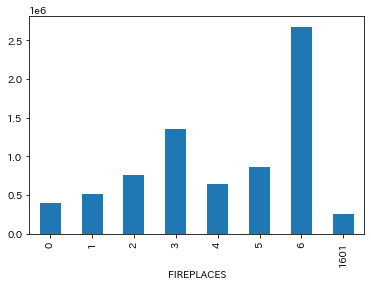

In [1142]:
category("FIREPLACES",train_df_all)

In [1143]:
test_df_all["FIREPLACES"].value_counts()

0       2781
1        447
2         14
3          3
1017       1
Name: FIREPLACES, dtype: int64

In [1144]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["FIREPLACES"]<5]

## BATHRM/HF_BATHRM

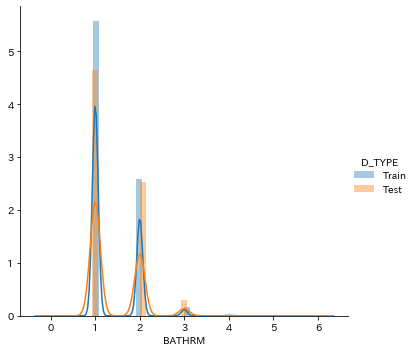

In [1145]:
dist_tt("BATHRM")

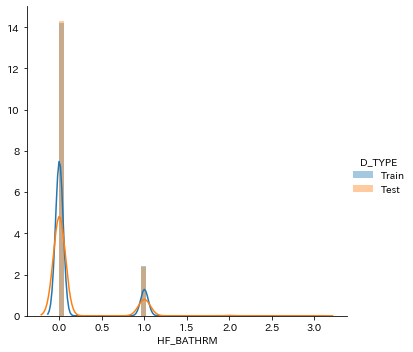

In [1146]:
dist_tt("HF_BATHRM")

In [1147]:
#BATHROOMとHFBATHROOMは合計の値を説明変数にする
train_df_all["BATHRM_ALL"] = train_df_all['BATHRM'] + train_df_all["HF_BATHRM"]
test_df_all["BATHRM_ALL"] = test_df_all['BATHRM'] + test_df_all["HF_BATHRM"]

## ROOMS/BEDROOMS

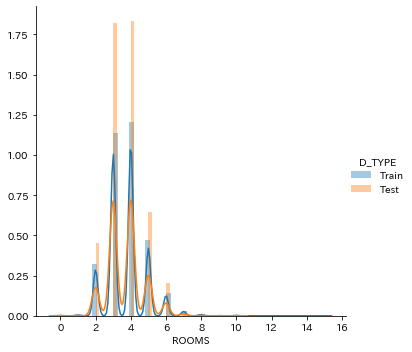

In [1148]:
dist_tt("ROOMS")

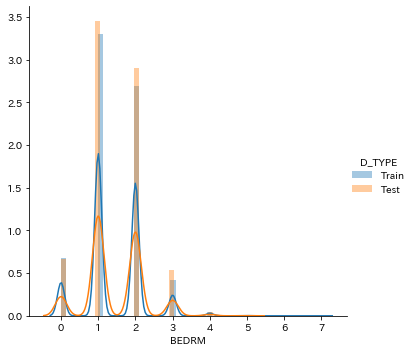

In [1149]:
dist_tt("BEDRM")

In [1150]:
#ROOMの合計はROOMSとBEDRMの合計とする
train_df_all["ROOM_ALL"] = train_df_all['ROOMS'] + train_df_all['BEDRM']
test_df_all["ROOM_ALL"] = test_df_all['ROOMS'] + test_df_all['BEDRM']

## AYB

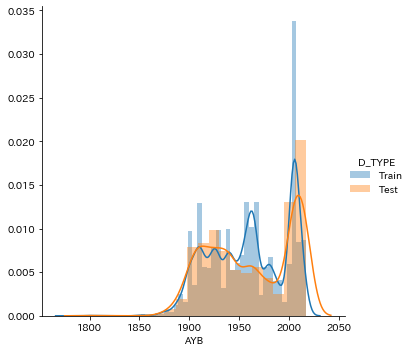

In [1151]:
dist_tt("AYB")

In [1152]:
#AYBの欠損値補完
#ほとんどの場合でAYBとEYBは同じ。AYBの欠損値はEYBで補完
train_df_all["AYB"] = train_df_all["AYB"].fillna(value=train_df_all["EYB"])
test_df_all["AYB"] = test_df_all["AYB"].fillna(value=test_df_all["EYB"])

In [1153]:
train_df_all["AYB"].describe()

count    33210.000000
mean      1959.076483
std         38.200543
min       1780.000000
25%       1927.000000
50%       1960.000000
75%       2002.000000
max       2017.000000
Name: AYB, dtype: float64

In [1154]:
train_df_all['AYB_GROUP']  = train_df_all['AYB'].astype(float)
bins =  [1770] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['AYB_GROUP'] = pd.cut(train_df_all['AYB'], bins=bins, labels = labels)

AYB_GROUP
1770-1850    633370.833333
1850-1860    343911.433333
1860-1870    499701.575758
1870-1880    553994.559783
1880-1890    480545.922693
1890-1900    418722.395287
1900-1910    446500.898564
1910-1920    464433.133368
1920-1930    336439.366420
1930-1940    263839.293569
1940-1950    290791.107549
1950-1960    271329.158513
1960-1970    338410.829248
1970-1980    438216.003492
1980-1990    480435.342354
1990-2000    544078.746761
2000-2010    533123.093445
2010-2020    621478.394448
Name: PRICE, dtype: float64

AYB_GROUP
1770-1850      24
1850-1860      30
1860-1870      33
1870-1880     184
1880-1890     401
1890-1900    1867
1900-1910    2228
1910-1920    1912
1920-1930    2972
1930-1940    2037
1940-1950    1934
1950-1960    3148
1960-1970    3672
1970-1980    1718
1980-1990    1589
1990-2000     849
2000-2010    7063
2010-2020    1549
Name: PRICE, dtype: int64

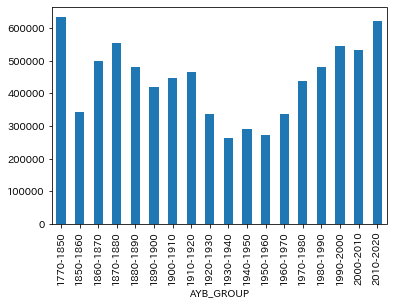

In [1155]:
category("AYB_GROUP",train_df_all)

In [1156]:
test_df_all["AYB"].describe()

count    3246.000000
mean     1961.960259
std        42.418503
min      1800.000000
25%      1924.000000
50%      1961.000000
75%      2006.000000
max      2017.000000
Name: AYB, dtype: float64

In [1157]:
test_df_all['AYB_GROUP']  = test_df_all['AYB'].astype(float)
bins =  [1770] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['AYB_GROUP'] = pd.cut(test_df_all['AYB'], bins=bins, labels = labels)

## YR_RMDL

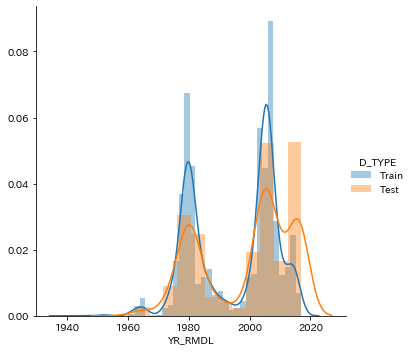

In [1158]:
dist_tt("YR_RMDL")

In [1159]:
train_df_all["YR_RMDL"].describe()

count    20094.000000
mean      1995.128844
std         13.880492
min       1940.000000
25%       1981.000000
50%       2003.000000
75%       2006.000000
max       2017.000000
Name: YR_RMDL, dtype: float64

In [1160]:
test_df_all["YR_RMDL"].describe()

count    1905.000000
mean     1999.001575
std        14.982535
min      1958.000000
25%      1982.000000
50%      2004.000000
75%      2011.000000
max      2017.000000
Name: YR_RMDL, dtype: float64

In [1161]:
a = train_df_all[["AYB", "AYB_GROUP","YR_RMDL"]]
b = test_df_all[["AYB","AYB_GROUP","YR_RMDL"]]
a = a[~a["YR_RMDL"].isnull()]
b = b[~b["YR_RMDL"].isnull()]

temp_yr = pd.concat([a,b],axis=0)

In [1162]:
temp_yr["duration"] = temp_yr["YR_RMDL"] - temp_yr["AYB"]
temp_yr["duration"].describe()

count    21999.000000
mean        54.287195
std         35.054864
min        -28.000000
25%         21.000000
50%         55.000000
75%         81.000000
max        236.000000
Name: duration, dtype: float64

In [1163]:
temp_yr=temp_yr[temp_yr["duration"] > 0]

In [1164]:
fill_rmyr = temp_yr.groupby("AYB_GROUP").duration.mean().reset_index()
fill_rmyr.index = fill_rmyr["AYB_GROUP"]

In [1165]:
fill_rmyr["duration"] = fill_rmyr["duration"].fillna(0)

In [1166]:
ym_ave = fill_rmyr.to_dict(orient="dict")["duration"]

In [1167]:
ym_ave

{'1770-1850': 194.66666666666666,
 '1850-1860': 154.06666666666666,
 '1860-1870': 131.83333333333334,
 '1870-1880': 117.29292929292929,
 '1880-1890': 104.63908045977011,
 '1890-1900': 96.5047143649473,
 '1900-1910': 88.29944938585345,
 '1910-1920': 81.69602415702063,
 '1920-1930': 68.79694019471488,
 '1930-1940': 58.14307228915663,
 '1940-1950': 48.49441687344913,
 '1950-1960': 37.23431542461005,
 '1960-1970': 24.161219081272083,
 '1970-1980': 17.026584867075666,
 '1980-1990': 15.396153846153846,
 '1990-2000': 12.444444444444445,
 '2000-2010': 2.4037267080745344,
 '2010-2020': 0.0}

In [1168]:
def fill_YRRMDL(x):
    x=ym_ave[x]
    return x

train_df_all["YRRM_AVE"] = train_df_all["AYB_GROUP"]
test_df_all["YRRM_AVE"] = test_df_all["AYB_GROUP"]
train_df_all["YRRM_AVE"] = train_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)
test_df_all["YRRM_AVE"] = test_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)

In [1169]:
train_df_all["YRRM_AVE"] = train_df_all["AYB"] + train_df_all["YRRM_AVE"]
test_df_all["YRRM_AVE"]  = test_df_all["AYB"] + test_df_all["YRRM_AVE"]
train_df_all["YR_RMDL"] = train_df_all["YR_RMDL"].fillna(value=train_df_all["YRRM_AVE"])
test_df_all["YR_RMDL"] = test_df_all["YR_RMDL"].fillna(value=test_df_all["YRRM_AVE"])

In [1170]:
train_df_all["YR_RMDL"].isnull().sum()

0

In [1171]:
test_df_all["YR_RMDL"].isnull().sum()

0

In [1172]:
train_df_all["YR_RMDL"].describe()

count    33210.000000
mean      1998.139601
std         12.559371
min       1940.000000
25%       1988.000000
50%       2003.444444
75%       2007.403727
max       2017.000000
Name: YR_RMDL, dtype: float64

In [1173]:
train_df_all['RM_GROUP']  = train_df_all['YR_RMDL'].astype(float)
bins =  [1930] + [i for i in range(1970, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['RM_GROUP'] = pd.cut(train_df_all['YR_RMDL'], bins=bins, labels = labels)

RM_GROUP
1930-1970    366298.187166
1970-1980    292471.521318
1980-1990    367738.636964
1990-2000    380350.395642
2000-2010    434221.740412
2010-2020    588129.820995
Name: PRICE, dtype: float64

RM_GROUP
1930-1970      374
1970-1980     4644
1980-1990     4242
1990-2000     5323
2000-2010    13845
2010-2020     4782
Name: PRICE, dtype: int64

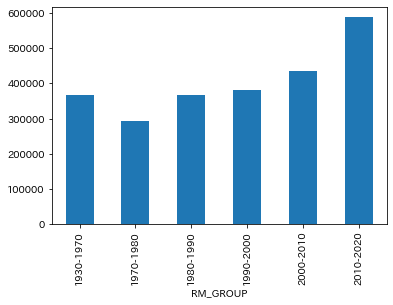

In [1174]:
category("RM_GROUP",train_df_all)

In [1175]:
test_df_all["YR_RMDL"].describe()

count    3246.000000
mean     2002.164063
std        13.360659
min      1958.000000
25%      1993.234315
50%      2006.000000
75%      2014.000000
max      2017.000000
Name: YR_RMDL, dtype: float64

In [1176]:
test_df_all['RM_GROUP']  = test_df_all['YR_RMDL'].astype(float)
bins =  [1930] + [i for i in range(1970, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['RM_GROUP'] = pd.cut(test_df_all['YR_RMDL'], bins=bins, labels = labels)

## AC

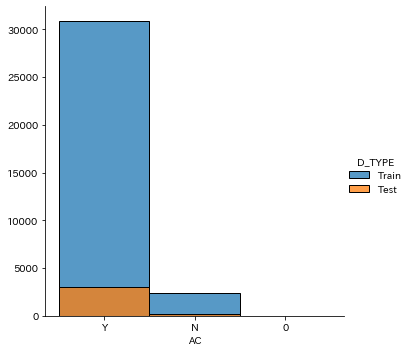

In [1177]:
hist_tt("AC")

In [1178]:
#ACのカテゴリー変換
#0はNとして補完
def ac_mod(x):
    if x == 0:
        x="N"
        return x
    elif x == "N":
        x="N"
        return x
    else:
        x="Y"
        return x
    

train_df_all["AC"]=train_df_all["AC"].apply(lambda x: ac_mod(x))
test_df_all["AC"]=test_df_all["AC"].apply(lambda x: ac_mod(x))

## SALEDATE

In [1179]:
#SALE_DATEはYEARに変換
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(str)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

SALEDATE_YEAR
1986      5400.000000
1988     80500.000000
1990     70900.000000
1992    140655.377049
1993    117688.620690
1994    127210.621495
1995    120952.247525
1996    120719.606796
1997    108585.486590
1998    122980.491409
1999    143492.022222
2000    170572.130019
2001    207780.903010
2002    228863.522911
2003    257965.840319
2004    323295.886086
2005    432590.234586
2006    401279.286377
2007    402291.068031
2008    425814.460753
2009    389768.726309
2010    527291.776331
2011    419213.069149
2012    433324.913784
2013    461863.458763
2014    537365.770164
2015    497948.492281
2016    507052.655751
Name: PRICE, dtype: float64

SALEDATE_YEAR
1986       1
1988       1
1990       1
1992     244
1993     174
1994     214
1995     202
1996     206
1997     261
1998     291
1999     315
2000     523
2001     598
2002     742
2003    1002
2004    1308
2005    1995
2006    1725
2007    1955
2008    1567
2009    1604
2010    1766
2011    1504
2012    1995
2013    2716
2014    3050
2015    3433
2016    3817
Name: PRICE, dtype: int64

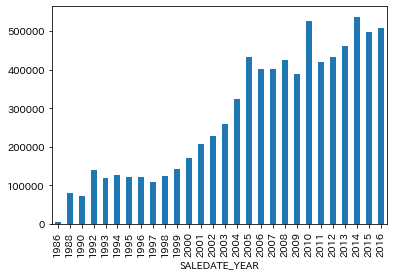

In [1180]:
category("SALEDATE_YEAR",train_df_all)

In [1181]:
train_df_all['SALEDATE_YEAR']  = train_df_all['SALEDATE_YEAR'].astype(float)
bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['SALEDATE_YEAR'] = pd.cut(train_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)

SALEDATE_YEAR
1980-1995    127371.516129
1995-2000    139978.436717
2000-2005    325675.823384
2005-2010    429653.403853
2010-2015    480219.214522
2015-2020    507052.655751
Name: PRICE, dtype: float64

SALEDATE_YEAR
1980-1995      837
1995-2000     1596
2000-2005     5645
2005-2010     8617
2010-2015    12698
2015-2020     3817
Name: PRICE, dtype: int64

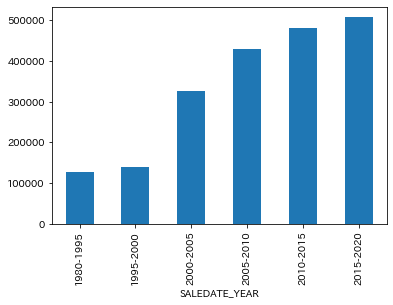

In [1182]:
category("SALEDATE_YEAR",train_df_all)

In [1183]:
#SALE_DATEはYEARに変換
test_df_all["SALEDATE"] = pd.to_datetime(test_df_all["SALEDATE"])
test_df_all["SALEDATE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
test_df_all["SALEDATE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(str)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

In [1184]:
test_df_all["SALEDATE_YEAR"].describe()

count     3246
unique       1
top       2017
freq      3246
Name: SALEDATE_YEAR, dtype: object

In [1185]:
test_df_all['SALEDATE_YEAR']  = test_df_all['SALEDATE_YEAR'].astype(float)
bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['SALEDATE_YEAR'] = pd.cut(test_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)

In [1186]:
train_df_all[train_df_all["SALEDATE_YEAR"].isna()]

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH


In [1187]:
train_df_all["SALEDATE_YEAR"][25976] = train_df_all["SALEDATE_YEAR"].mode()

## QUADRANT

QUADRANT
NE    322823.285948
NW    447363.187855
SE    362333.530246
SW    280550.293062
Name: PRICE, dtype: float64

QUADRANT
NE     3053
NW    25030
SE     3455
SW     1672
Name: PRICE, dtype: int64

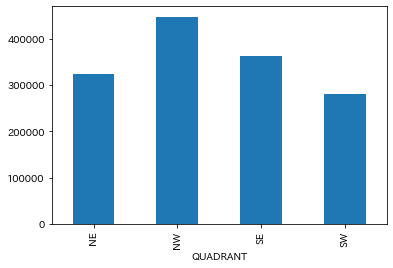

In [1188]:
#QUADRANT 欠損値補完
#QUADRANT NAはここでは最頻値で補完。後ほどLocationの情報をもとに補完。
category("QUADRANT",train_df_all)

In [1189]:
train_df_all["QUADRANT"].mode()[0]

'NW'

In [1190]:
train_df_all["QUADRANT"] = train_df_all["QUADRANT"].replace(np.nan,str(train_df_all["QUADRANT"].mode()[0]))
test_df_all["QUADRANT"] = test_df_all["QUADRANT"].replace(np.nan,str(test_df_all["QUADRANT"].mode()[0]))

In [1191]:
train_df_all["QUADRANT"].unique()

array(['NW', 'SE', 'NE', 'SW'], dtype=object)

## QUALIFIED

QUALIFIED
Q    397075.618905
U    488048.753140
Name: PRICE, dtype: float64

QUALIFIED
Q    25327
U     7883
Name: PRICE, dtype: int64

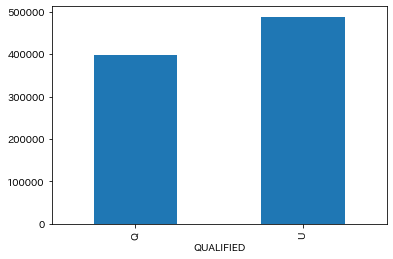

In [1192]:
#CNDTNの欠損値補完
category("QUALIFIED",train_df_all)

In [1193]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["QUALIFIED"] == "Q"]

In [1194]:
test_df_all["QUALIFIED"].unique()

array(['Q'], dtype=object)

## LAND AREA

In [1195]:
train_df_all["LANDAREA"].describe()

count    25327.000000
mean       503.944012
std        531.714189
min          0.000000
25%        178.000000
50%        338.000000
75%        632.000000
max      20152.000000
Name: LANDAREA, dtype: float64

In [1196]:
test_df_all["LANDAREA"].describe()

count    3246.000000
mean      487.681762
std       461.964925
min         0.000000
25%       190.000000
50%       347.000000
75%       638.000000
max      4306.000000
Name: LANDAREA, dtype: float64

In [1197]:
(df_all["LANDAREA"] > 5000).sum()

12

In [1198]:
df_all = df_all[df_all["LANDAREA"] < 5000]
train_df_all = train_df_all[train_df_all["LANDAREA"] < 5000]

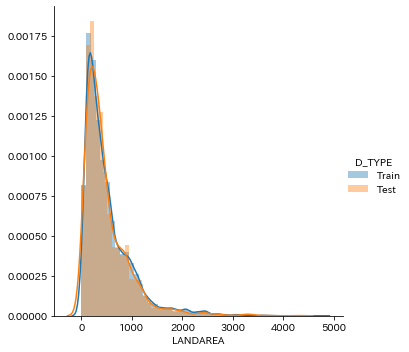

In [1199]:
dist_tt("LANDAREA")

[(0.0, 12000000.0)]

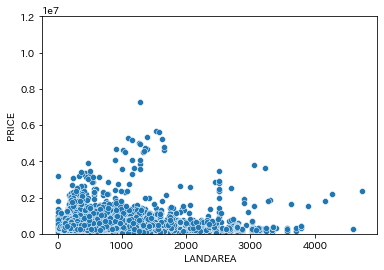

In [1200]:
g=sns.scatterplot(data=train_df_all,x="LANDAREA",y="PRICE")
g.set(ylim=(0,12000000))

## SQUARE

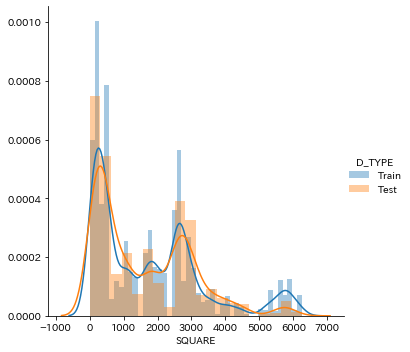

In [1201]:
dist_tt("SQUARE")

[(0.0, 12000000.0)]

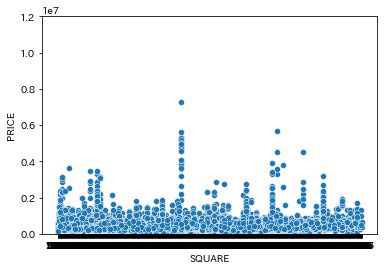

In [1202]:
g=sns.scatterplot(data=train_df_all,x="SQUARE",y="PRICE")
g.set(ylim=(0,12000000))

## WARD

WARD
Ward 1    427830.827011
Ward 2    475707.065501
Ward 3    353599.331761
Ward 4    288914.654709
Ward 5    310554.208581
Ward 6    383578.906115
Ward 7    161910.010376
Ward 8    162762.326329
Name: PRICE, dtype: float64

WARD
Ward 1    5035
Ward 2    8290
Ward 3    3605
Ward 4     892
Ward 5    1515
Ward 6    4399
Ward 7     771
Ward 8     809
Name: PRICE, dtype: int64

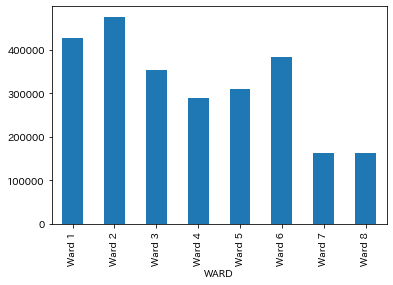

In [1203]:
category("WARD",train_df_all)

## LOCATION

<AxesSubplot:xlabel='LATITUDE', ylabel='LONGITUDE'>

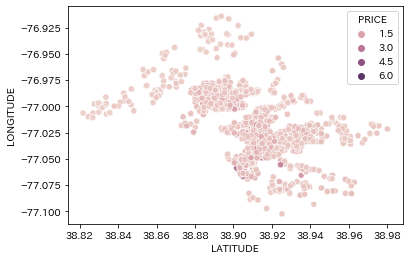

In [1204]:
sns.scatterplot(data = train_df_all, x=train_df_all["LATITUDE"] ,y=train_df_all["LONGITUDE"], hue="PRICE")

In [1205]:
#train_df_all = train_df_all.copy()
#temp_df = train_df_all[train_df_all["PRICE"] < 1000000]
temp_df = train_df_all.copy()

In [1206]:
temp_df["LATITUDE"].describe()

count    25316.000000
mean        38.910921
std          0.022434
min         38.821792
25%         38.900439
50%         38.911719
75%         38.924149
max         38.980019
Name: LATITUDE, dtype: float64

In [1207]:
temp_df["LATITUDE"]  = temp_df["LATITUDE"].astype(float)
bins =  np.arange(38.80, 39.00, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LATITUDE_GROUP"] = pd.cut(temp_df["LATITUDE"], bins=bins, labels = labels)

In [1208]:
bins

array([38.8  , 38.805, 38.81 , 38.815, 38.82 , 38.825, 38.83 , 38.835,
       38.84 , 38.845, 38.85 , 38.855, 38.86 , 38.865, 38.87 , 38.875,
       38.88 , 38.885, 38.89 , 38.895, 38.9  , 38.905, 38.91 , 38.915,
       38.92 , 38.925, 38.93 , 38.935, 38.94 , 38.945, 38.95 , 38.955,
       38.96 , 38.965, 38.97 , 38.975, 38.98 , 38.985, 38.99 , 38.995,
       39.   ])

In [1209]:
temp_df

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,LATITUDE_GROUP
4,4,1,0,Wall Furnace,Y,3,1,1918.0,1979.000000,1918,1986-06-10,Q,2,0,17,235,1233.0,585.0,38.934151,-77.037394,Mt. Pleasant,036 A Mt. Pleasant,2701.0,Ward 1,2622,NW,5400.0,1,4,1910-1920,1999.696024,1970-1980,1980-1995,6,38.9325
6,6,1,0,Forced Air,Y,4,1,1957.0,1978.000000,1957,1988-04-13,Q,1,0,17,260,3004.0,826.0,38.961282,-77.075658,Chevy Chase,011 A Chevy Chase,1100.0,Ward 3,1857,NW,80500.0,1,5,1950-1960,1994.234315,1970-1980,1980-1995,4,38.9625
8,8,1,0,Ht Pump,Y,5,2,1940.0,1975.000000,1940,1990-05-17,Q,2,0,16,1622,1280.0,861.0,38.864448,-76.951306,Hillcrest,028 C Hillcrest,7603.0,Ward 7,5673,SE,70900.0,1,7,1930-1940,1998.143072,1970-1980,1980-1995,5,38.8625
16,16,1,0,Ht Pump,N,3,1,1936.0,1994.143072,1936,1992-01-02,Q,1,0,16,557,3028.0,547.0,38.935702,-76.989725,Brookland,007 C Brookland,9504.0,Ward 5,3926,NE,60000.0,1,4,1930-1940,1994.143072,1990-2000,1980-1995,1,38.9375
18,18,1,0,Forced Air,Y,3,1,1981.0,1981.000000,1981,1992-01-02,Q,1,0,17,129,2255.0,678.0,38.906273,-77.028972,Old City 2,040 C Old City 2,5002.0,Ward 2,281,NW,287625.0,1,4,1980-1990,1996.396154,1980-1990,1980-1995,1,38.9075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82643,82643,1,0,Wall Furnace,Y,3,1,1954.0,2007.000000,1954,2016-12-30,Q,3,0,16,522,2863.0,525.0,38.910098,-77.087175,Palisades,041 B Palisades,802.0,Ward 3,1367,NW,262500.0,1,4,1950-1960,1991.234315,2000-2010,2015-2020,12,38.9125
82644,82644,2,0,Forced Air,Y,4,2,2007.0,2009.403727,2007,2016-12-30,Q,4,0,17,117,2871.0,888.0,38.900439,-77.015750,Old City 2,040 B Old City 2,4702.0,Ward 6,528,NW,601500.0,2,6,2000-2010,2009.403727,2000-2010,2015-2020,12,38.9025
82645,82645,1,0,Ht Pump,N,4,1,1989.0,2004.396154,1989,2016-12-30,Q,4,0,17,147,1010.0,581.0,38.905876,-77.050606,Central-tri 1,NaN,5500.0,Ward 2,0036,NW,412000.0,1,5,1980-1990,2004.396154,2000-2010,2015-2020,12,38.9075
82649,82649,1,0,Ht Pump,Y,4,1,1900.0,2003.000000,1919,2016-12-30,Q,3,0,16,657,3056.0,556.0,38.960740,-77.032749,16th Street Heights,049 A 16th Street Heights,2001.0,Ward 4,2794,NW,221000.0,1,5,1890-1900,1996.504714,2000-2010,2015-2020,12,38.9625


In [1210]:
temp_df["LATITUDE_GROUP"] = temp_df["LATITUDE_GROUP"].replace(np.nan,0)

In [1211]:
temp_df["LONGITUDE"].describe()

count    25316.000000
mean       -77.029382
std          0.029604
min        -77.102570
25%        -77.046343
50%        -77.030957
75%        -77.016301
max        -76.914173
Name: LONGITUDE, dtype: float64

In [1212]:
temp_df["LONGITUDE"]  = temp_df["LONGITUDE"].astype(float)
bins =  np.arange(-77.12, -76.89, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LONGITUDE_GROUP"] = pd.cut(temp_df["LONGITUDE"], bins=bins, labels = labels)

In [1213]:
temp_df

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,LATITUDE_GROUP,LONGITUDE_GROUP
4,4,1,0,Wall Furnace,Y,3,1,1918.0,1979.000000,1918,1986-06-10,Q,2,0,17,235,1233.0,585.0,38.934151,-77.037394,Mt. Pleasant,036 A Mt. Pleasant,2701.0,Ward 1,2622,NW,5400.0,1,4,1910-1920,1999.696024,1970-1980,1980-1995,6,38.9325,-77.0375
6,6,1,0,Forced Air,Y,4,1,1957.0,1978.000000,1957,1988-04-13,Q,1,0,17,260,3004.0,826.0,38.961282,-77.075658,Chevy Chase,011 A Chevy Chase,1100.0,Ward 3,1857,NW,80500.0,1,5,1950-1960,1994.234315,1970-1980,1980-1995,4,38.9625,-77.0775
8,8,1,0,Ht Pump,Y,5,2,1940.0,1975.000000,1940,1990-05-17,Q,2,0,16,1622,1280.0,861.0,38.864448,-76.951306,Hillcrest,028 C Hillcrest,7603.0,Ward 7,5673,SE,70900.0,1,7,1930-1940,1998.143072,1970-1980,1980-1995,5,38.8625,-76.9525
16,16,1,0,Ht Pump,N,3,1,1936.0,1994.143072,1936,1992-01-02,Q,1,0,16,557,3028.0,547.0,38.935702,-76.989725,Brookland,007 C Brookland,9504.0,Ward 5,3926,NE,60000.0,1,4,1930-1940,1994.143072,1990-2000,1980-1995,1,38.9375,-76.9875
18,18,1,0,Forced Air,Y,3,1,1981.0,1981.000000,1981,1992-01-02,Q,1,0,17,129,2255.0,678.0,38.906273,-77.028972,Old City 2,040 C Old City 2,5002.0,Ward 2,281,NW,287625.0,1,4,1980-1990,1996.396154,1980-1990,1980-1995,1,38.9075,-77.0275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82643,82643,1,0,Wall Furnace,Y,3,1,1954.0,2007.000000,1954,2016-12-30,Q,3,0,16,522,2863.0,525.0,38.910098,-77.087175,Palisades,041 B Palisades,802.0,Ward 3,1367,NW,262500.0,1,4,1950-1960,1991.234315,2000-2010,2015-2020,12,38.9125,-77.0875
82644,82644,2,0,Forced Air,Y,4,2,2007.0,2009.403727,2007,2016-12-30,Q,4,0,17,117,2871.0,888.0,38.900439,-77.015750,Old City 2,040 B Old City 2,4702.0,Ward 6,528,NW,601500.0,2,6,2000-2010,2009.403727,2000-2010,2015-2020,12,38.9025,-77.0175
82645,82645,1,0,Ht Pump,N,4,1,1989.0,2004.396154,1989,2016-12-30,Q,4,0,17,147,1010.0,581.0,38.905876,-77.050606,Central-tri 1,NaN,5500.0,Ward 2,0036,NW,412000.0,1,5,1980-1990,2004.396154,2000-2010,2015-2020,12,38.9075,-77.0525
82649,82649,1,0,Ht Pump,Y,4,1,1900.0,2003.000000,1919,2016-12-30,Q,3,0,16,657,3056.0,556.0,38.960740,-77.032749,16th Street Heights,049 A 16th Street Heights,2001.0,Ward 4,2794,NW,221000.0,1,5,1890-1900,1996.504714,2000-2010,2015-2020,12,38.9625,-77.0325


In [1214]:
temp_df_2 = temp_df.groupby(["LONGITUDE_GROUP","LATITUDE_GROUP"]).PRICE.agg(["mean","count"]).reset_index()
temp_df_2["LONGITUDE_GROUP"] = temp_df_2["LONGITUDE_GROUP"].astype(float)
temp_df_2["LATITUDE_GROUP"] = temp_df_2["LATITUDE_GROUP"].astype(float)
temp_df_fol=temp_df_2.query("count > 20").reset_index(drop=True)


In [1215]:
temp_df_fol

,LONGITUDE_GROUP,LATITUDE_GROUP,mean,count
0,-77.1025,38.9275,252253.448276,29
1,-77.0975,38.9175,268510.806452,31
2,-77.0875,38.9125,312787.402299,87
3,-77.0825,38.9225,248727.512605,119
4,-77.0825,38.9275,193723.736842,95
...,...,...,...,...
172,-76.9475,38.8825,80936.478261,23
173,-76.9425,38.8925,143887.000000,51
174,-76.9375,38.8875,167917.682540,63
175,-76.9325,38.8875,190741.436364,55


In [1216]:

def map_scaling(df):
    
    base_amount = min(df["mean"])

    # 円の大きさの倍率
    scale = 40

    # 地図の定義
    map = folium.Map(location=[38.9, -77], zoom_start=12)

    # 販売量を円の大きさで表す
    for index, row in df.iterrows():
        location = (row["LATITUDE_GROUP"], row["LONGITUDE_GROUP"])   # 座標
        radius = scale * (row["mean"] / base_amount) # 円の大きさ
        # 円を地図に追加
        folium.Circle(location=location,      # 地点の緯度経度
                    radius=radius,          # 円の大きさ
                    color="darkblue",       # 円の色
                    fill_color="darkblue",  # 円内の色
                    popup=row["count"]       # マウスオーバー時の表示項目
        ).add_to(map)
    return map

map_scaling(temp_df_fol)

In [1217]:
temp_df_fol["mean"].sort_values(ascending=False)

23     1.506400e+06
9      1.173112e+06
19     1.033541e+06
126    8.692820e+05
39     8.580435e+05
           ...     
169    1.098980e+05
111    1.096041e+05
110    9.491786e+04
158    8.637174e+04
172    8.093648e+04
Name: mean, Length: 177, dtype: float64

In [1218]:
temp_df_fol.iloc[23]

LONGITUDE_GROUP   -7.706250e+01
LATITUDE_GROUP     3.890250e+01
mean               1.506400e+06
count              9.300000e+01
Name: 23, dtype: float64

In [1219]:
#base_long = -77.048
#base_lat = 38.9184
base_long = temp_df_fol.iloc[23].LONGITUDE_GROUP
base_lat = temp_df_fol.iloc[23].LATITUDE_GROUP

In [1220]:
train_df_all.head()

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH
4,4,1,0,Wall Furnace,Y,3,1,1918.0,1979.000000,1918,1986-06-10,Q,2,0,17,235,1233.0,585.0,38.934151,-77.037394,Mt. Pleasant,036 A Mt. Pleasant,2701.0,Ward 1,2622,NW,5400.0,1,4,1910-1920,1999.696024,1970-1980,1980-1995,6
6,6,1,0,Forced Air,Y,4,1,1957.0,1978.000000,1957,1988-04-13,Q,1,0,17,260,3004.0,826.0,38.961282,-77.075658,Chevy Chase,011 A Chevy Chase,1100.0,Ward 3,1857,NW,80500.0,1,5,1950-1960,1994.234315,1970-1980,1980-1995,4
8,8,1,0,Ht Pump,Y,5,2,1940.0,1975.000000,1940,1990-05-17,Q,2,0,16,1622,1280.0,861.0,38.864448,-76.951306,Hillcrest,028 C Hillcrest,7603.0,Ward 7,5673,SE,70900.0,1,7,1930-1940,1998.143072,1970-1980,1980-1995,5
16,16,1,0,Ht Pump,N,3,1,1936.0,1994.143072,1936,1992-01-02,Q,1,0,16,557,3028.0,547.0,38.935702,-76.989725,Brookland,007 C Brookland,9504.0,Ward 5,3926,NE,60000.0,1,4,1930-1940,1994.143072,1990-2000,1980-1995,1
18,18,1,0,Forced Air,Y,3,1,1981.0,1981.000000,1981,1992-01-02,Q,1,0,17,129,2255.0,678.0,38.906273,-77.028972,Old City 2,040 C Old City 2,5002.0,Ward 2,281,NW,287625.0,1,4,1980-1990,1996.396154,1980-1990,1980-1995,1


In [1221]:
from geopy.distance import geodesic

def calculate_distance(row):
    base_point=(base_lat,base_long)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE"] =train_df_all.apply(calculate_distance,axis=1)
test_df_all["DISTANCE"] =test_df_all.apply(calculate_distance,axis=1)
    

[(0.0, 12000000.0)]

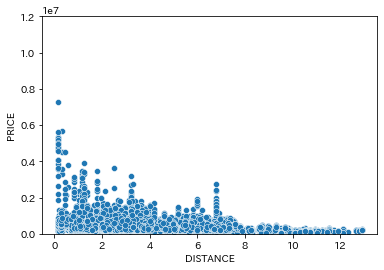

In [1222]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE",y="PRICE")
g.set(ylim=(0,12000000))

### Duplicate Check

In [1223]:
train_df_all.columns

Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB',
       'YR_RMDL', 'EYB', 'SALEDATE', 'QUALIFIED', 'SALE_NUM', 'FIREPLACES',
       'USECODE', 'LANDAREA', 'CMPLX_NUM', 'LIVING_GBA', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'WARD', 'SQUARE', 'QUADRANT', 'PRICE', 'BATHRM_ALL', 'ROOM_ALL',
       'AYB_GROUP', 'YRRM_AVE', 'RM_GROUP', 'SALEDATE_YEAR', 'SALEDATE_MONTH',
       'DISTANCE'],
      dtype='object')

In [1224]:
train_df_all["LOC_DUP"] = train_df_all["LATITUDE"]+train_df_all["LONGITUDE"]

In [1225]:
train_df_all[train_df_all.duplicated(subset="PRICE")]

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,DISTANCE,LOC_DUP
54,54,2,0,Ht Pump,Y,4,2,1908.0,1981.000000,1908,1992-01-22,Q,1,1,17,315,2116.0,1141.0,38.913219,-77.039134,Old City 2,040 D Old City 2,5301.0,Ward 2,154,NW,205000.0,2,6,1900-1910,1996.299449,1980-1990,1980-1995,1,2.350211,-38.125915
74,74,1,0,Hot Water Rad,N,3,1,1927.0,1983.000000,1927,1992-01-29,Q,1,0,17,202,1114.0,596.0,38.916464,-77.045027,Kalorama,029 B Kalorama,4002.0,Ward 1,2535,NW,95000.0,1,4,1920-1930,1995.796940,1980-1990,1980-1995,1,2.167967,-38.128563
112,112,1,0,Hot Water Rad,N,4,1,1929.0,1997.796940,1929,1992-02-28,Q,1,0,17,460,1084.0,887.0,38.929605,-77.057050,Garfield,NaN,502.0,Ward 3,2106,NW,160000.0,1,5,1920-1930,1997.796940,1990-2000,1980-1995,2,3.045978,-38.127445
179,179,1,0,Ht Pump,Y,2,1,1991.0,2003.444444,1991,1992-03-27,Q,1,0,17,73,3037.0,490.0,38.894305,-77.022462,Central-tri 3,NaN,5800.0,Ward 2,408,NW,215800.0,1,3,1990-2000,2003.444444,2000-2010,1980-1995,3,3.590433,-38.128157
188,188,1,0,Forced Air,Y,3,1,1900.0,1978.000000,1900,1992-03-31,Q,1,0,17,137,2138.0,703.0,38.910524,-77.039982,Old City 2,040 D Old City 2,5301.0,Ward 2,156,NW,105000.0,1,4,1890-1900,1996.504714,1970-1980,1980-1995,3,2.146750,-38.129458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82636,82636,1,0,Ht Pump,Y,2,0,2016.0,2016.000000,2016,2016-12-29,Q,2,0,17,193,5326.0,472.0,38.879979,-76.982869,Old City 1,039 B Old City 1,6802.0,Ward 6,1077,SE,325000.0,1,2,2010-2020,2016.000000,2010-2020,2015-2020,12,7.347167,-38.102890
82643,82643,1,0,Wall Furnace,Y,3,1,1954.0,2007.000000,1954,2016-12-30,Q,3,0,16,522,2863.0,525.0,38.910098,-77.087175,Palisades,041 B Palisades,802.0,Ward 3,1367,NW,262500.0,1,4,1950-1960,1991.234315,2000-2010,2015-2020,12,2.300530,-38.177077
82645,82645,1,0,Ht Pump,N,4,1,1989.0,2004.396154,1989,2016-12-30,Q,4,0,17,147,1010.0,581.0,38.905876,-77.050606,Central-tri 1,NaN,5500.0,Ward 2,0036,NW,412000.0,1,5,1980-1990,2004.396154,2000-2010,2015-2020,12,1.097674,-38.144730
82649,82649,1,0,Ht Pump,Y,4,1,1900.0,2003.000000,1919,2016-12-30,Q,3,0,16,657,3056.0,556.0,38.960740,-77.032749,16th Street Heights,049 A 16th Street Heights,2001.0,Ward 4,2794,NW,221000.0,1,5,1890-1900,1996.504714,2000-2010,2015-2020,12,6.961075,-38.072009


## LIVING_GBA

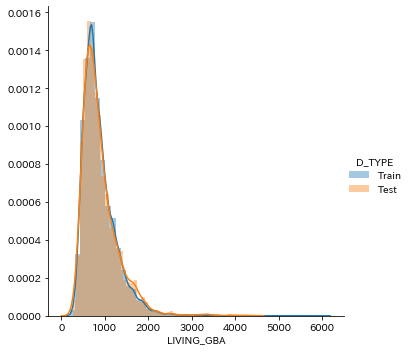

In [1226]:
dist_tt("LIVING_GBA")

[(0.0, 12000000.0)]

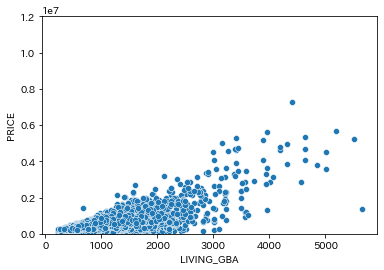

In [1227]:
g=sns.scatterplot(data=train_df_all,x="LIVING_GBA",y="PRICE")
g.set(ylim=(0,12000000))

## SALE_NUM

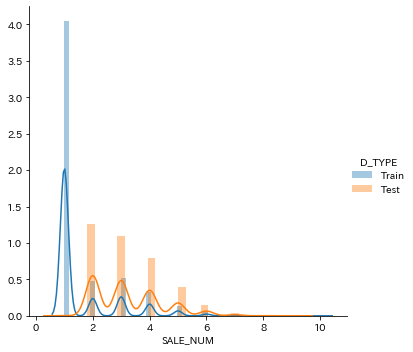

In [1228]:
dist_tt("SALE_NUM")

SALE_NUM
1     359666.593222
2     516911.288489
3     490126.613494
4     484658.560667
5     474078.150082
6     505200.240741
7     450659.021739
8     360158.333333
9     535000.000000
10    624900.000000
Name: PRICE, dtype: float64

SALE_NUM
1     18413
2      2111
3      2401
4      1500
5       613
6       216
7        46
8        12
9         3
10        1
Name: PRICE, dtype: int64

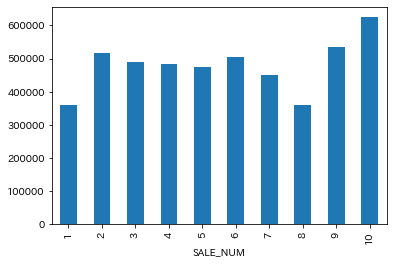

In [1229]:
category("SALE_NUM",train_df_all)

In [1230]:
train_df_all["SALE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)
test_df_all["SALE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
test_df_all["SALE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

In [1231]:
#train_df_all["BULD_AGE"] = 2016 - train_df_all["AYB"]
#test_df_all["BULD_AGE"] = 2016 - test_df_all["AYB"]
train_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - train_df_all["AYB"]
test_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - test_df_all["AYB"]

In [1232]:
train_df_all["BULD_AGE"]

4         68.0
6         31.0
8         50.0
16        56.0
18        11.0
         ...  
82643     62.0
82644      9.0
82645     27.0
82649    116.0
82650      1.0
Name: BULD_AGE, Length: 25316, dtype: float64

<AxesSubplot:xlabel='BULD_AGE', ylabel='PRICE'>

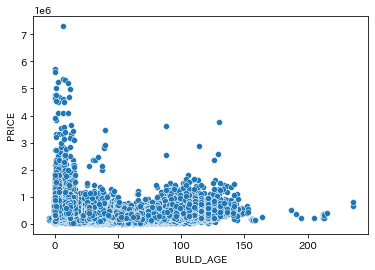

In [1233]:
sns.scatterplot(data=train_df_all,x="BULD_AGE",y="PRICE")

In [1234]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["BULD_AGE"] > 0]
train_df_all["LIV_DUR"] = train_df_all["BULD_AGE"] / train_df_all["SALE_NUM"]

test_df_all = test_df_all.copy()
#test_df_all = test_df_all[test_df_all["LIV_DUR"] > 0]
test_df_all["LIV_DUR"] = test_df_all["BULD_AGE"] / test_df_all["SALE_NUM"]

[(0.0, 12000000.0)]

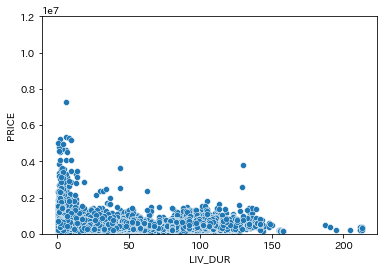

In [1235]:
g=sns.scatterplot(data=train_df_all,x="LIV_DUR",y="PRICE")
g.set(ylim=(0,12000000))

## COMPLEX_NUM

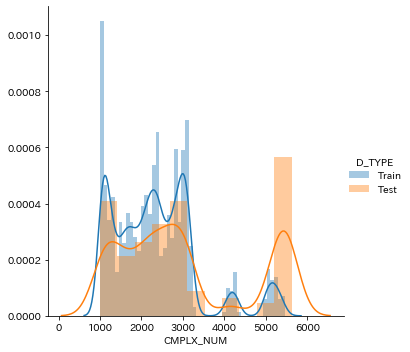

In [1236]:
dist_tt("CMPLX_NUM")

[(0.0, 12000000.0)]

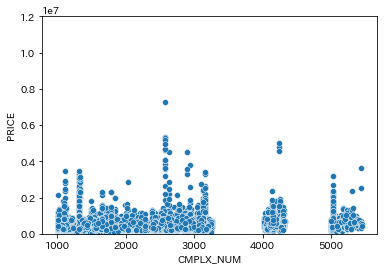

In [1237]:
g=sns.scatterplot(data=train_df_all,x="CMPLX_NUM",y="PRICE")
g.set(ylim=(0,12000000))

In [1238]:
train_df_all

,Id,BATHRM,HF_BATHRM,HEAT,AC,ROOMS,BEDRM,AYB,YR_RMDL,EYB,SALEDATE,QUALIFIED,SALE_NUM,FIREPLACES,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,YRRM_AVE,RM_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,DISTANCE,LOC_DUP,SALE_YEAR,SALE_MONTH,BULD_AGE,LIV_DUR
4,4,1,0,Wall Furnace,Y,3,1,1918.0,1979.000000,1918,1986-06-10,Q,2,0,17,235,1233.0,585.0,38.934151,-77.037394,Mt. Pleasant,036 A Mt. Pleasant,2701.0,Ward 1,2622,NW,5400.0,1,4,1910-1920,1999.696024,1970-1980,1980-1995,6,4.133626,-38.103243,1986.0,6.0,68.0,34.000000
6,6,1,0,Forced Air,Y,4,1,1957.0,1978.000000,1957,1988-04-13,Q,1,0,17,260,3004.0,826.0,38.961282,-77.075658,Chevy Chase,011 A Chevy Chase,1100.0,Ward 3,1857,NW,80500.0,1,5,1950-1960,1994.234315,1970-1980,1980-1995,4,6.624580,-38.114376,1988.0,4.0,31.0,31.000000
8,8,1,0,Ht Pump,Y,5,2,1940.0,1975.000000,1940,1990-05-17,Q,2,0,16,1622,1280.0,861.0,38.864448,-76.951306,Hillcrest,028 C Hillcrest,7603.0,Ward 7,5673,SE,70900.0,1,7,1930-1940,1998.143072,1970-1980,1980-1995,5,10.532384,-38.086858,1990.0,5.0,50.0,25.000000
16,16,1,0,Ht Pump,N,3,1,1936.0,1994.143072,1936,1992-01-02,Q,1,0,16,557,3028.0,547.0,38.935702,-76.989725,Brookland,007 C Brookland,9504.0,Ward 5,3926,NE,60000.0,1,4,1930-1940,1994.143072,1990-2000,1980-1995,1,7.308872,-38.054023,1992.0,1.0,56.0,56.000000
18,18,1,0,Forced Air,Y,3,1,1981.0,1981.000000,1981,1992-01-02,Q,1,0,17,129,2255.0,678.0,38.906273,-77.028972,Old City 2,040 C Old City 2,5002.0,Ward 2,281,NW,287625.0,1,4,1980-1990,1996.396154,1980-1990,1980-1995,1,2.938315,-38.122699,1992.0,1.0,11.0,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82643,82643,1,0,Wall Furnace,Y,3,1,1954.0,2007.000000,1954,2016-12-30,Q,3,0,16,522,2863.0,525.0,38.910098,-77.087175,Palisades,041 B Palisades,802.0,Ward 3,1367,NW,262500.0,1,4,1950-1960,1991.234315,2000-2010,2015-2020,12,2.300530,-38.177077,2016.0,12.0,62.0,20.666667
82644,82644,2,0,Forced Air,Y,4,2,2007.0,2009.403727,2007,2016-12-30,Q,4,0,17,117,2871.0,888.0,38.900439,-77.015750,Old City 2,040 B Old City 2,4702.0,Ward 6,528,NW,601500.0,2,6,2000-2010,2009.403727,2000-2010,2015-2020,12,4.061826,-38.115311,2016.0,12.0,9.0,2.250000
82645,82645,1,0,Ht Pump,N,4,1,1989.0,2004.396154,1989,2016-12-30,Q,4,0,17,147,1010.0,581.0,38.905876,-77.050606,Central-tri 1,NaN,5500.0,Ward 2,0036,NW,412000.0,1,5,1980-1990,2004.396154,2000-2010,2015-2020,12,1.097674,-38.144730,2016.0,12.0,27.0,6.750000
82649,82649,1,0,Ht Pump,Y,4,1,1900.0,2003.000000,1919,2016-12-30,Q,3,0,16,657,3056.0,556.0,38.960740,-77.032749,16th Street Heights,049 A 16th Street Heights,2001.0,Ward 4,2794,NW,221000.0,1,5,1890-1900,1996.504714,2000-2010,2015-2020,12,6.961075,-38.072009,2016.0,12.0,116.0,38.666667


In [1239]:
train_df_all["STYLES"]

KeyError: 'STYLES'

## Summary

In [ ]:
test_df_all.columns

In [ ]:
train_df_all.columns

In [ ]:
train_df_all = train_df_all[['QUADRANT',"ASSESSMENT_NBHD","FIREPLACES" ,"LIV_DUR",'BATHRM_ALL','ROOM_ALL', 'AYB_GROUP','SALEDATE_YEAR' ,"RM_GROUP",'LIVING_GBA','AC', 'DISTANCE',"LANDAREA","WARD",'PRICE']]
test_df_all = test_df_all[['Id',"ASSESSMENT_NBHD",'QUADRANT',"FIREPLACES", "LIV_DUR", 'BATHRM_ALL','ROOM_ALL', 'AYB_GROUP', 'SALEDATE_YEAR',"RM_GROUP", 'LIVING_GBA','AC','DISTANCE',"LANDAREA","WARD"]]

In [ ]:
train_df_all.isnull().sum()

In [ ]:
test_df_all.isnull().sum()

In [ ]:
set(train_df_all.columns)^set(test_df_all.columns)

In [ ]:
train_df_cond_dum = pd.get_dummies(data=train_df_all,columns=['AC',"ASSESSMENT_NBHD", 'SALEDATE_YEAR','QUADRANT', 'AYB_GROUP',"RM_GROUP","WARD"]).reset_index(drop=True)
test_df_cond_dum = pd.get_dummies(data=test_df_all,columns=['AC',"ASSESSMENT_NBHD", 'SALEDATE_YEAR','QUADRANT',  'AYB_GROUP',"RM_GROUP","WARD"])

In [ ]:
set(train_df_cond_dum.columns)^set(test_df_cond_dum.columns)

In [ ]:
train_df_cond_dum.to_pickle("./data/train_df_cond_dum.pkl")
test_df_cond_dum.to_pickle("./data/test_df_cond_dum.pkl")